In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib
import zarr
import os

matplotlib.rcParams['pdf.fonttype'] = 42  # makes fonts editable in Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.pyplot.rcParams.update({
    "pgf.preamble": [
         "\\usepackage{arev}",
        "\\usepackage[T1]{fontenc}"]
})

# Likelihood

[Text(0.5, 1.0, 'projection of Z onto two dimensions')]

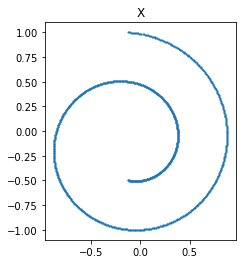

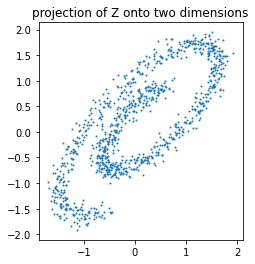

In [2]:
np.random.seed(0)
torch.random.manual_seed(1)
from rad_utils import select_model, generate_2d_swiss_roll
num_samples = 1000
t, clean_manifold, min, max = generate_2d_swiss_roll(num_samples, rescaled=True)
t = torch.tensor(t)
clean_manifold = torch.tensor(clean_manifold, dtype=torch.float)

# plot the clean manifold, X
fig, ax = plt.subplots(1, 1)
ax.scatter(*clean_manifold.T, s=1)
ax.set_aspect('equal')
ax.set(title='X')

'''
now apply a transformation to a higher dimensional space
X = L * Z + 0.1 * epsilon
p(x | z) = N(Lz, 0.2 I)
'''

X_dim = 10
Z_dim = clean_manifold.shape[1]
L = torch.randn(X_dim, Z_dim, dtype=torch.float)
zarr.save('saved_arrays/L.zarr', L.numpy())
epsilon = torch.randn(X_dim, num_samples, dtype=torch.float)
sigma = 0.1
X = torch.mm(L,clean_manifold.T) + sigma*epsilon

x0, x1, x2 = X[0, :], X[1, :], X[2, :]

fig, ax = plt.subplots(1, 1)
ax.scatter(x0, x1, s=1)
ax.set_aspect('equal')
ax.set(title='projection of Z onto two dimensions')

prob is 0.9407843947410583


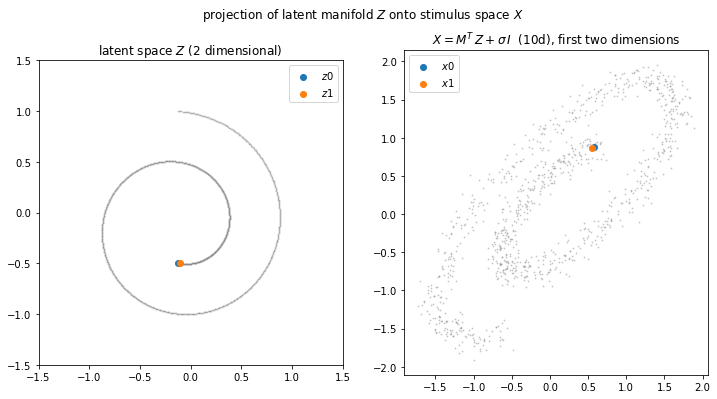

In [3]:
# this is the code for generating a likelihood for a given z_t
def calculate_x_from_z(z_t, L, sigma, seed=None):
    '''
    transforms the latent space Z to the data space X
    '''
    if seed is not None:
        torch.random.manual_seed(seed)
    num_samples = z_t.shape[0]
    Z_dim = z_t.shape[1]
    assert L.shape[1] == Z_dim
    X_dim = L.shape[0]
    
    epsilon = torch.randn(X_dim, num_samples)
    X = torch.mm(L, z_t.T) + sigma*epsilon
    return X

z_0 = clean_manifold[0, :].reshape(1, -1)
test_x = calculate_x_from_z(z_0, L, sigma)

def compute_likelihood(z_i, x, L, sigma):
    '''
    computes p(X = x_i | Z = z_i)
    Given a data point z_i, compute the likelihood of observing x
    '''
    x_mean = torch.mm(L, z_i.T)
    assert x_mean.shape == x.shape
    
    prob = torch.exp(-torch.sum(torch.square(x - x_mean), axis=0) / (2 * sigma**2))
    # prob = prob.requires_grad_(True)
    return prob

z_0 = clean_manifold[0, :].reshape(1, -1)
z_1 = clean_manifold[5, :].reshape(1, -1)

# using L from the previous cell, create ground truth observable x_0 from ground truth latent z_0 
sigma=0.01
x_0 = calculate_x_from_z(z_0, L, sigma, seed=0)
x_1 = calculate_x_from_z(z_1, L, sigma, seed=0)

# now calculate the likelihood of observing x_0 given z_0
sigma=0.1
prob = compute_likelihood(z_0, x_0, L, sigma)

# plot the location of z_0 and z_1
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(*clean_manifold.T, s=1, alpha=0.3, c='grey')
ax[0].scatter(*z_0.T, label='$z0$')
ax[0].scatter(*z_1.T, label='$z1$')
ax[0].set_aspect('equal')
ax[0].set(xlim=[-1.5, 1.5], ylim=[-1.5, 1.5])
ax[0].set(title='latent space $Z$ (2 dimensional)')
ax[0].legend()

X = calculate_x_from_z(clean_manifold, L, sigma)

ax[1].scatter(*X[0:2, :], s=1, alpha=0.3, c='grey')
ax[1].scatter(*x_0[:2, :], label='$x0$')
ax[1].scatter(*x_1[:2, :], label='$x1$')
ax[1].set_aspect('equal')
ax[1].set(title='$X=M^T \, Z + \sigma\, I$  (10d), first two dimensions')
ax[1].legend()

fig.suptitle('projection of latent manifold $Z$ onto stimulus space $X$')

print('prob is', prob.item())

# Inference

okay now that we have the likelihood $p(X|Z)$, we can sample from the posterior $p(Z|X)$. 

Suppose we have a point $x_i$. We want to guide the diffusion process to sample from the posterior $p(Z | X= x_i)$. 

We can set up the problem in the following way. 
First, start with the a known latent value of $z_i$, and map it into the stimulus space X to get $x_i$. 
Now that you have a pair of $(x_i, z_i)$, use the diffusion step $p(z_t | z_{t+1}, x_i) = N(\mu + s\Sigma g, \Sigma)$ where $g = \nabla_{z_t} \log p(x_i | z_t) \mid_{z_t = \mu}$ and $\Sigma = I$. 

This should result in a $z_0$, a sample from the prior that is constrained by the observation $x_i$. 

Considerations:
- how do I compute the gradient of $\log p(x_i | z_t)$?


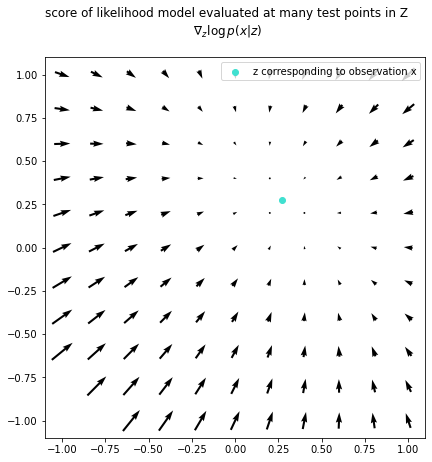

In [4]:
def compute_log_likelihood(z_i, x, L, sigma):
    return torch.log(compute_likelihood(z_i, x, L, sigma))

def compute_likelihood_score(z, x, L, sigma):
    '''
    takes in the likelihood model and computes the score for a given data point x
    '''
    z = z.detach().requires_grad_(True)
    probs = compute_likelihood(z, x, L, sigma)
    logits = torch.log(probs)  # this is = log p(x|z)
    # print(logits)
    return torch.autograd.grad(logits, z, torch.ones_like(logits))[0]


# creating the ground truth
z_gt = clean_manifold[250, :].view(1, -1)

# x_0 = calculate_x_from_z(z_0, L, sigma=0.01, seed=0)
z_tests = clean_manifold[20:5000:10, :]

z_obss = []
for i in np.linspace(-1, 1, 11):
    z_obs = np.linspace(start=[-i, 1], stop=[-i, -1], num=11)
    z_obss.append(z_obs)
z_obss = np.vstack(z_obss)
z_obss = torch.tensor(z_obss, dtype=torch.float)

x_obss = calculate_x_from_z(z_obss, L, sigma=0.0, seed=0)
# computing the likelihood that observable x_tests came from latent z_gt
scores = []
for x_obs in x_obss.T:
    score = compute_likelihood_score(z_gt, x_obs.reshape(-1, 1), L, sigma=0.40)
    scores.append(score)
scores = torch.stack(scores).reshape(-1, 2)
# scores = scores/torch.norm(scores, dim=0)**0.6

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
fig.suptitle('score of likelihood model evaluated at many test points in Z\n $\\nabla_z \log p(x|z)$')
ax.scatter(*z_gt.T, c='turquoise', label='z corresponding to observation x')
# ax.scatter(*z_obss.T, alpha=0.8, c='red')
# ax.set(xlim=[-.5, 0], ylim=[-0.6, 0])
ax.quiver(*z_obss.T, *-scores.T,
            angles = 'xy',
            scale_units = 'width',
            scale = 1500,
            pivot = 'mid',)
ax.set_aspect('equal')
ax.legend(loc='upper right')

embedding dimension is 2
model loaded!
the model has 34050 parameters


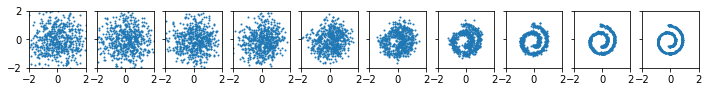

In [5]:
from likelihood_utils import compute_likelihood_score, calculate_x_from_z, compute_likelihood

# p(x | z) = N(Lz, 0.2 I)
from rad_utils import select_model, plot_reverse_samples_10_steps
prior_sampler, num_steps, embedding_dims = select_model('unconditional-concat', 9)

alphas, betas, one_minus_alphas_prod_sqrt, z_seq = plot_reverse_samples_10_steps(prior_sampler, num_samples, embedding_dims, num_steps)

# sampling from the posterior. Suppose we have a point x_i. We want to guide the diffusion process to sample from the posterior p(z | x_i). 
from likelihood_utils import posterior_sample_loop

sample_size = int(5e2)
s=0.2
sigma=0.4

x_i = calculate_x_from_z(z_gt, L, sigma=0.0, seed=0)

z_seq = posterior_sample_loop(prior_sampler, x_i, L, sigma, s, (sample_size, embedding_dims), num_steps)


Text(0.5, 0.98, 'sampling from the posterior distribution')

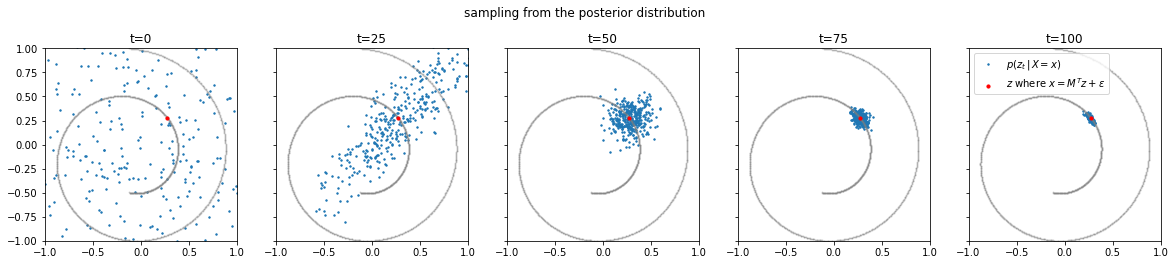

In [6]:
z_seq_np = z_seq.detach().numpy()

fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)
idx = 0
for i in np.linspace(0, 100, 5):
    ax[idx].scatter(*z_seq_np[int(i)].T, s=2, label='$p(z_t\,|\,X=x)$')
    ax[idx].scatter(*clean_manifold.T, s=1, alpha=0.3, c='grey')
    ax[idx].scatter(*z_gt.T, s=10, c='red', label='$z$ where $x=M^Tz+\epsilon$')
    ax[idx].set(title=f't={int(i)}')
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=[-1, 1], ylim=[-1, 1])
    idx += 1
ax[-1].legend()
fig.suptitle('sampling from the posterior distribution')

# inverse problems

what do we do with this likelihood? solve inverse problems! 

let's consider an occlusion problem. okay so suppose you have some constraint on one of the latent variable axes, e.g. $Z_1 = 0.5$. Then what is the value of $Z_2$? From the plot of Z we see that it can take 2 values. This is like holding one of the two latent "pixels" fixed, and asking you what could be the value of the other latent pixel. 

This is almost the same problem as the inference procedure we did above, except now the "ground truth" is no longer a single point on the manifold, $x_i$, but a set of points that satisfies the constraint $Z_1 = 0.5$. 

how can our likelihood help? well it provides us with extra information, $p(z_0 | x)$, which we can use to guide the sampling process towards the right latent pixel. 

The steps:
1. first, select a point in the latent space, z_0
2. calculate the log likelihood of this point, p(x | z_0)
3. replace one of the pixels with random noise
4. perform forward diffusion on the point z_0 -> z_T
5. using the posterior sampling algorithm and the log likelihood from before, anti-diffuse onto z_hat_0

Difficulties:
- how to navigate the different dimension sizes in Z and X

## "Deterministic" constraint

[[2.21880078]]


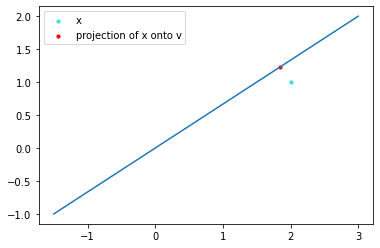

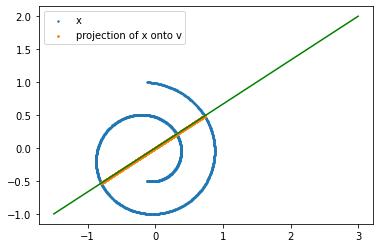

In [7]:
# coding up the math in zahra's work
np.random.seed(0)

v = np.array([[3, 2]]).T
x = np.array([[2, 1]]).T
# x are all the points in the manifold

ls = np.linspace(-.5, 1, 100)

# M = 1/(np.dot(v.T, v)) * v @ v.T
M = v / np.linalg.norm(v)
Mm = M @ M.T

length = M.T @ x
print(length)
projection = Mm @ x

# now try using this with another test point
fig, ax = plt.subplots(1, 1)
ax.plot(ls * v[0], ls * v[1])
ax.scatter(*x, s=10, c='turquoise', label='x')
ax.scatter(*projection, s=10, c='red', label='projection of x onto v')
ax.legend()

# now for the manifold
xs = clean_manifold.T
projected = Mm @ xs.detach().numpy()

fig, ax = plt.subplots(1, 1)
ax.plot(ls * v[0], ls * v[1], c='green')
ax.scatter(*xs, s=2, label='x')
ax.scatter(*projected, s=3, label='projection of x onto v')
ax.legend()


## computing the log likelihood

tensor([[-0.3546,  0.5320]], grad_fn=<SubBackward0>)
tensor(0.4087, grad_fn=<PowBackward0>)
tensor([3.4952e-03, 5.3821e-18], grad_fn=<ExpBackward>)
tensor([ -5.6564, -39.7635], grad_fn=<LogBackward>)
tensor([[-0.7093,  1.0639]])


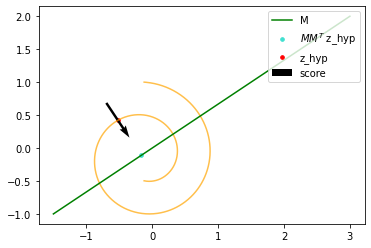

In [8]:
# so now what if we apply this to the diffusion process?
from likelihood_utils import compute_likelihood, compute_log_likelihood, compute_likelihood_score

v = np.array([[3, 2]]).T
M = v / np.linalg.norm(v)
Mm = M @ M.T

# first get a likelihood
# z_gt = clean_manifold[0, :].reshape(1, -1)
z_hyp = clean_manifold[400, :].reshape(1, -1)
M_ch = torch.from_numpy(M).float().T
Mm_ch = torch.from_numpy(Mm).float()

# z_c = Mz_c = torch.mm(Mm_ch.T, z_hyp.T).T  # equivalent to "x_obs", the projection of z_hyp onto v
z_c = (Mm_ch@z_hyp.T).T
v_ch = torch.from_numpy(v).float().T

sigma=0.01

# calculate the score
z_hyp = z_hyp.requires_grad_(True)
residual = z_hyp - z_c
# residual = (torch.eye(2) - Mm_ch) @ z_hyp.T
print(residual)
dist = torch.norm(residual)**2
print(dist)
score = torch.autograd.grad(dist, z_hyp, torch.ones_like(dist))[0]

prob = compute_likelihood(z_hyp, z_c, M_ch, sigma)
log_llh = compute_log_likelihood(z_hyp, z_c, M_ch, sigma)


print(prob)
print(log_llh)
print(score)

z_hyp = z_hyp.detach().numpy()

fig, ax = plt.subplots(1,1)
ax.plot(*clean_manifold.T, c='orange', alpha=0.7)
ax.plot(ls * v[0], ls * v[1], c='green', label='M')
ax.scatter(*z_c.T, s=13, c='turquoise', label='$M M^T$ z_hyp')
ax.scatter(*z_hyp.T, s=13, c='red', label='z_hyp')
ax.quiver(*z_hyp.T, *-score.T,
            angles = 'xy',
            scale_units = 'width',
            scale = 10,
            pivot = 'mid',
            label='score'
            )
ax.set_aspect('equal')
ax.legend(loc='upper right')


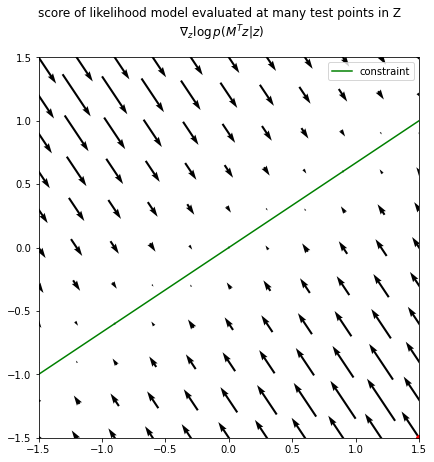

In [9]:
z_hyps = []
for i in np.linspace(-1.5, 1.5, 11):
    z_hyp = np.linspace(start=[-i, 1.5], stop=[-i, -1.5], num=11)
    z_hyps.append(z_hyp)
z_hyps = np.vstack(z_hyps)
z_hyps = torch.tensor(z_hyps, dtype=torch.float)

M = v / np.linalg.norm(v)
Mm = M @ M.T
Mm = torch.from_numpy(Mm).float()

from likelihood_utils import compute_occlusion_score
scores = compute_occlusion_score(z_hyps, Mm, sigma=0.1)


fig, ax = plt.subplots(1, 1, figsize=(10, 7))
fig.suptitle('score of likelihood model evaluated at many test points in Z\n $\\nabla_z \log p(M^T z|z)$')
# ax.scatter(*z_obss.T, alpha=0.8, c='red')
lims = [-1.5, 1.5]
ax.set(xlim=lims, ylim=lims)
ls = np.linspace(-1, 1, 100)
ax.plot(ls * v[0], ls * v[1], c='green', label='constraint')
ax.quiver(*z_hyps.T, *scores.T,
            angles = 'xy',
            scale_units = 'width',
            scale = 1250,
            pivot = 'mid',)
ax.scatter(*z_hyps[10].T, c='red')
ax.set_aspect('equal')
ax.legend(loc='upper right')

## sampling from the posterior for a deterministic constraint

In [4]:
from rad_utils import select_model, plot_reverse_samples_10_steps

prior_sampler, num_steps, embedding_dims = select_model('unconditional-concat', 9)
alphas, betas, one_minus_alphas_prod_sqrt, z_seq = plot_reverse_samples_10_steps(prior_sampler, num_samples, embedding_dims, num_steps)

# sampling from the posterior. Suppose we have a point x_i. We want to guide the diffusion process to sample from the posterior p(z | x_i). 
from likelihood_utils import posterior_sample_loop_occlusion

sample_size = int(5e2)
s=0.5
sigma=0.2

v = np.array([[4, 1]]).T
M = v / np.linalg.norm(v)

z_seq = posterior_sample_loop_occlusion(prior_sampler, M, sigma, s, (sample_size, embedding_dims), num_steps)


embedding dimension is 2
model loaded!
the model has 34050 parameters


NameError: name 'num_samples' is not defined

Text(0.5, 0.98, 'sampling from the posterior distribution')

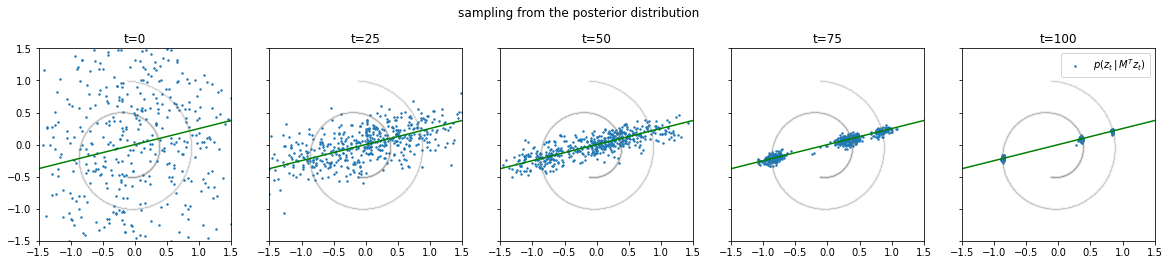

In [296]:
z_seq_np = z_seq.detach().numpy()

lims = [-1.5, 1.5]

fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)
idx = 0
for i in np.linspace(0, 100, 5):
    ax[idx].scatter(*z_seq_np[int(i)].T, s=2, label='$p(z_t\,|\,M^T z_t)$')
    ax[idx].scatter(*clean_manifold.T, s=1, alpha=0.1, c='grey')
    # ax[idx].scatter(*z_gt.T, s=10, c='red', label='$z$ where $x=M^Tz+\epsilon$')
    ax[idx].plot(ls * v[0], ls * v[1], c='green')
    ax[idx].set(title=f't={int(i)}')
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=lims, ylim=lims)
    idx += 1
ax[-1].legend()
fig.suptitle('sampling from the posterior distribution')

## non-deterministic constraint

### flow field for likelihood

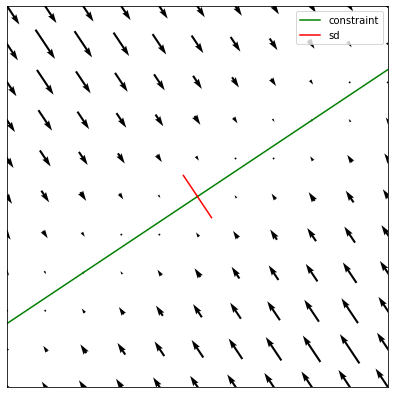

In [298]:
v = np.array([[3, 2]]).T

M = v / np.linalg.norm(v)
Mm = M @ M.T
Mm = torch.from_numpy(Mm).float()

constraint_sigma = 0.2
v_ortho = np.array([[2, -3]]).T
v_ortho_norm = v_ortho / np.linalg.norm(v_ortho)

# computing the score
scores = []
for z_hyp in z_hyps:
    z_hyp = z_hyp.reshape(1, -1).requires_grad_(True)
    # residual = z_hyp - z_c = (I - MM^T) z_hyp
    residual = (torch.eye(2) - Mm) @ z_hyp.T
    dist = torch.norm(residual)**2 / (2*constraint_sigma)
    score = torch.autograd.grad(dist, z_hyp, torch.ones_like(dist))[0]
    scores.append(score)
    # z_hyp = z_hyp.detach()
scores = torch.stack(scores).reshape(-1, 2)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
# fig.suptitle('score of likelihood model evaluated at many test points in Z\n $\\nabla_z \log p(M^T z|z)$')
# ax.scatter(*z_obss.T, alpha=0.8, c='red')
lims = [-1.5, 1.5]
ax.set(xlim=lims, ylim=lims)
ls = np.linspace(-1, 1, 100)
# blur the constraint line
# for i in np.arange(0.1, 1.01, 0.1):
    # ax.plot(ls * v[0], ls * v[1], c='green', linewidth=(7*i+0.1)**2, alpha=1/(i*30))
ax.plot(ls * v[0], ls * v[1], c='green', label='constraint')
# ax.plot(ls*v[0], ls*v[1], c='green', linewidth=50, alpha=0.3)
# instead of linewidth, use 

ls = np.linspace(-.2, .2, 100)
ax.plot(ls * v_ortho_norm[0], ls * v_ortho_norm[1], c='red', label='sd')

# color_size = np.hypot(scores[0], scores[1])**2

ax.quiver(*z_hyps.T, *-scores.T,
            cmap='Greys',
            angles = 'xy',
            scale_units = 'width',
            scale = 90,
            pivot = 'mid',)
ax.set_aspect('equal')
ax.legend(loc='upper right')
from rad_utils import remove_all_ticks_and_labels
remove_all_ticks_and_labels(ax)

save=False
if save==True:
    savedir = 'plots/neurips'
    figname = f'likelihood-flow-field-continuous.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

### show score flow field for the prior

In [ ]:
# display the flow field for the prior sampler 

lim_min = -1.5
lim_max = 1.5
num_samples = 15

def compute_diffuser_score(diffusion_model, x, t):
    '''
    computes the score of the diffusion model at a given point x
    score = -grad log p(x_t|x_t+1) = x_t - estimated mean = estimated error = model output 
    '''
    eps_theta = diffusion_model(x, t)
    return eps_theta

t = torch.tensor([0])

score_xs = []
score_ys = []
for sample_y in np.linspace(lim_max, lim_min, num_samples):
    for sample_x in np.linspace(lim_max,lim_min, num_samples):
        
        # compute the score 
        x = torch.tensor([[sample_x, sample_y]], dtype=torch.float)
        diffuser_score = compute_diffuser_score(prior_sampler, x, t=t).detach()
        
        # rescales vectors so you don't have such a huge difference between the largest and smallest
        diffuser_score = diffuser_score/torch.norm(diffuser_score, dim=1)**0.5
        
        score_x, score_y = -diffuser_score[0,0], -diffuser_score[0,1]
        
        # collect data
        score_xs.append(score_x)
        score_ys.append(score_y)
score_xs = torch.stack(score_xs).reshape(num_samples, num_samples)
score_ys = torch.stack(score_ys).reshape(num_samples, num_samples)

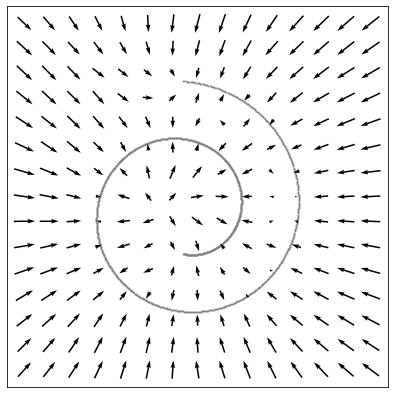

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(*clean_manifold.T, s=1, alpha=0.8, c='grey')
ax.quiver(np.linspace(lim_max, lim_min, num_samples), np.linspace(lim_max, lim_min, num_samples), 
          score_xs, score_ys, 
          angles='xy', scale_units='xy', scale=20, pivot='mid')
ax.set_aspect('equal')
from rad_utils import remove_all_ticks_and_labels
remove_all_ticks_and_labels(ax)

save=False
if save==True:
    savedir = 'plots/neurips'
    figname = f'prior-flow-field.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

### combining the flow fields for the prior and the likelihood

embedding dimension is 2
model loaded!
the model has 34050 parameters


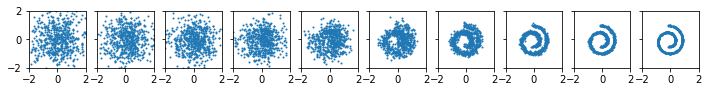

In [694]:

prior_sampler, num_steps, embedding_dims = select_model('unconditional-concat', 9)
alphas, betas, one_minus_alphas_prod_sqrt, z_seq = plot_reverse_samples_10_steps(prior_sampler, num_samples, embedding_dims, num_steps)

sample_size = int(5e2)
s=0.1
constraint_sigma = 0.1

M = v / np.linalg.norm(v)

z_seq = posterior_sample_loop_occlusion(prior_sampler, M, constraint_sigma, s, (sample_size, embedding_dims), num_steps, alphas, betas, one_minus_alphas_prod_sqrt)


(101, 500, 2)


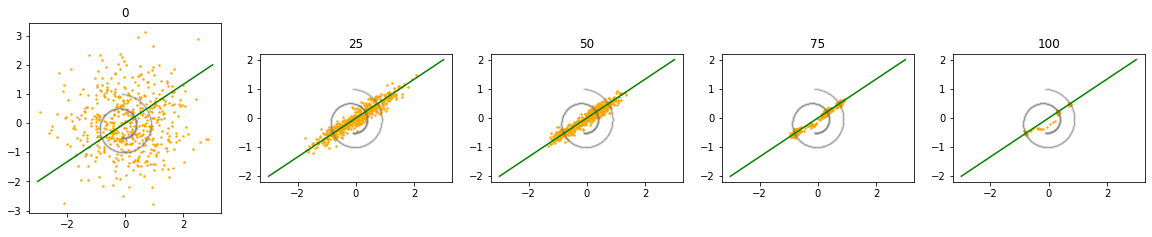

In [697]:
z_seq_np = z_seq.detach().numpy()
lims = [-1.5, 1.5]
print(z_seq_np.shape)
# z_seq_np = z_seq_np[:, :1, :]

# fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
idx = 0
for i in np.linspace(0, 100, 5):
    ax[idx].scatter(*z_seq_np[int(i)].T, s=2, label='$p(z_t\,|\,M^T z_t + \epsilon)$', color='orange')
    ax[idx].scatter(*clean_manifold.T, s=1, alpha=0.1, c='grey')
    # ax[idx].scatter(*z_gt.T, s=10, c='red', label='$z$ where $x=M^Tz+\epsilon$')
    ax[idx].plot(ls * v[0], ls * v[1], c='green')
    # ax[idx].set(title=f't={int(i)}')
    ax[idx].set_aspect('equal')
    # ax[idx].set(xlim=lims, ylim=lims)
    # remove_all_ticks_and_labels(ax[idx])
    ax[idx].set(title=f'{int(i)}')
    idx += 1
# ax[-1].legend()

save=True
if save==True:
    savedir = 'plots/neurips'
    figname = f'posterior-sampling-from-continuous-likelihood.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

# Combining multiple likelihoods

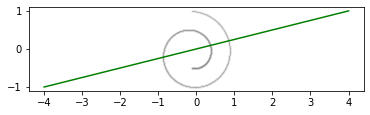

In [314]:
v = np.array([[4, 1]]).T
M = v / np.linalg.norm(v)
Mm = M @ M.T
Mm = torch.from_numpy(Mm).float()


fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
ax.scatter(*clean_manifold.T, s=1, alpha=0.1, c='grey')
ls = np.linspace(-1, 1, 100)
ax.plot(ls * v[0], ls * v[1], c='green')




# Sequential sampling from the posterior

## forward process (once)

In [698]:
# let's first try to plot how a batch of datapoints are transformed by one modified forward process
from likelihood_utils import posterior_sample_occlusion, reversed_forward_process_posterior_loop_occlusion
from generate_data import load_unimodal_data

num_samples_gt = 1000
data_roll_gt = load_unimodal_data(num_samples_gt, manifold_type='swiss_roll', noise=0.0, plot=False)
manifold_initial_point = data_roll_gt[np.random.randint(num_samples)].reshape(1, -1)

likelihood_sigma = 0.1

z_rf = reversed_forward_process_posterior_loop_occlusion(prior_sampler, data_roll_gt, M, likelihood_sigma, s, num_steps, alphas, betas, one_minus_alphas_prod_sqrt)
print(z_rf.shape)

# xf_rad = x_rad_seq[-1, :, :]

size of the training set is 1000
torch.Size([101, 1000, 2])


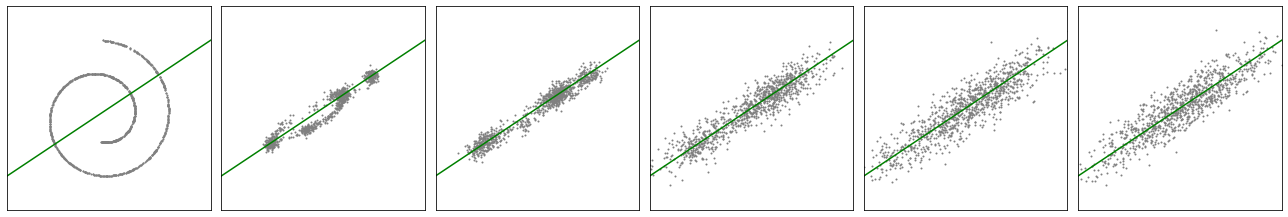

In [699]:
from rad_utils import remove_all_ticks_and_labels

ls = np.linspace(-1, 1, 100)

fig, ax = plt.subplots(1, 6, figsize=(18, 5), sharey=True)
ax_idx = 0
for idx, z_t in enumerate(z_rf):
    if idx % 20 == 0:
        z_t = z_t.detach().numpy()
        ax[ax_idx].plot(ls * v[0], ls * v[1], c='green')
        ax[ax_idx].scatter(*z_t.T, s=1,  c='grey' )
        
        ax[ax_idx].set_aspect('equal')
        lims = [-1.5, 1.5]
        ax[ax_idx].set(ylim=lims, xlim=lims)
        # ax[ax_idx].set(title=f'{idx}')
        remove_all_ticks_and_labels(ax[ax_idx])
        ax_idx += 1
fig.tight_layout()

save=True
if save==True:
    savedir = 'plots/neurips'
    figname = f'neural-forward-process-continuous-likelihood-6-snapshots.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)
        

## sequential sampling using the posterior forward process
### single run of 100 cycles

In [510]:
# rad ad + likelihood influence
from likelihood_utils import sequential_posterior_sampler

num_samples_in_gt_manifold = 5e3
clean_manifold_t, data_roll_gt, min, max = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)
# data_roll_gt = load_unimodal_data(num_samples_in_gt_manifold, manifold_type='swiss_roll', noise=0.0, plot=False)

# initialize a random point on the ground truth manifold and start the sequential posterior sampling
manifold_initial_point = data_roll_gt[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)

num_cycles = 1000

seq_sampled_points = []
seq_forward_points = []
seq_reverse_points = []
seq_sampled_point = manifold_initial_point
for j in range(num_cycles):
    seq_sampled_point, seq_forward, seq_reverse = sequential_posterior_sampler(prior_sampler, seq_sampled_point, M, likelihood_sigma, s, num_steps, alphas, betas, one_minus_alphas_prod_sqrt)
    
    seq_sampled_points.append(seq_sampled_point)
    seq_forward_points.append(seq_forward)
    seq_reverse_points.append(seq_reverse)
seq_sampled_points = torch.stack(seq_sampled_points).reshape(-1, 2)
seq_sampled_points = seq_sampled_points.detach().numpy()

seq_forward_points = torch.stack(seq_forward_points).reshape(num_cycles, -1, 2).detach().numpy()
seq_reverse_points = torch.stack(seq_reverse_points).reshape(num_cycles, -1, 2).detach().numpy()

print(seq_sampled_points.shape)
print(seq_forward_points.shape)
print(seq_reverse_points.shape)


/Users/blyo/Documents/research/thesis-lab/diffusion-model-exploration/likelihood_utils.py:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cur_z = torch.tensor(z, dtype=torch.float)


(1000, 2)
(1000, 101, 2)
(1000, 101, 2)


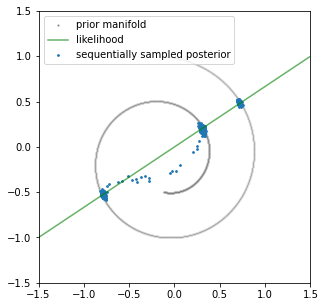

In [515]:
# plot the results of the sequential posterior sampling
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(*data_roll_gt[1200].T, s=1, alpha=1, c='grey', label='prior manifold')
ax.scatter(*data_roll_gt.T, s=1, alpha=0.05, c='grey')
ax.plot(ls * v[0], ls * v[1], c='green', alpha=0.6, label='likelihood')
ax.scatter(*seq_sampled_points.T, s=3, label='sequentially sampled posterior')
ax.set(xlim=lims, ylim=lims)
ax.set_aspect('equal')
ax.legend(loc="upper left")


Text(0.5, 0.98, 'sampling from the posterior distribution')

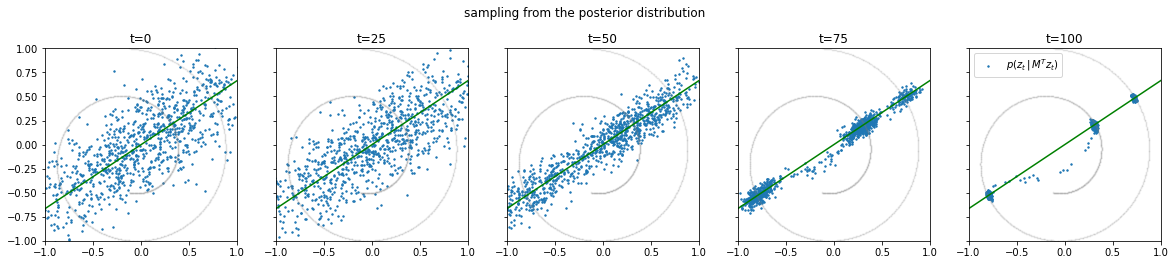

In [516]:
# plot the reverse process of the sequential posterior sampling at different temperatures
fig, ax = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)
idx = 0
for i in np.linspace(0, 100, 5):
    ax[idx].scatter(*seq_reverse_points[:, int(i)].T, s=2, label='$p(z_t\,|\,M^T z_t)$')
    ax[idx].scatter(*clean_manifold.T, s=1, alpha=0.1, c='grey')
    # ax[idx].scatter(*z_gt.T, s=10, c='red', label='$z$ where $x=M^Tz+\epsilon$')
    ax[idx].plot(ls * v[0], ls * v[1], c='green')
    ax[idx].set(title=f't={int(i)}')
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=[-1, 1], ylim=[-1, 1])
    idx += 1
ax[-1].legend()
fig.suptitle('sampling from the posterior distribution')